# LSTs and Drift Scans

#### David W. Barker

## Purpose:
This notebook is meant to be independent of the other beam_weighted notebooks in order to run some background calculations that will take quite some time.

## Neccessary Code


/home/dbarker7752/perses/perses/foregrounds/HaslamGalaxy.py:83: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  self._haslam_map_408 = hp.read_map(file_name, verbose=False)


Prepared Haslam map in 0.192 s.


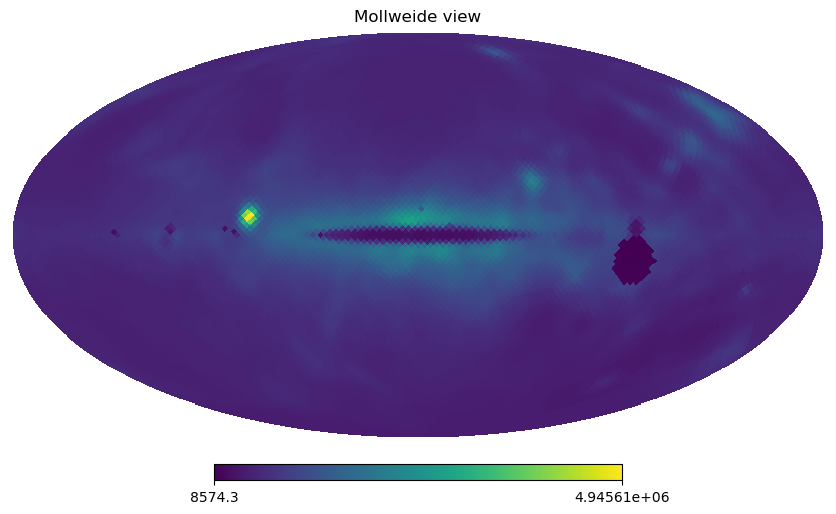

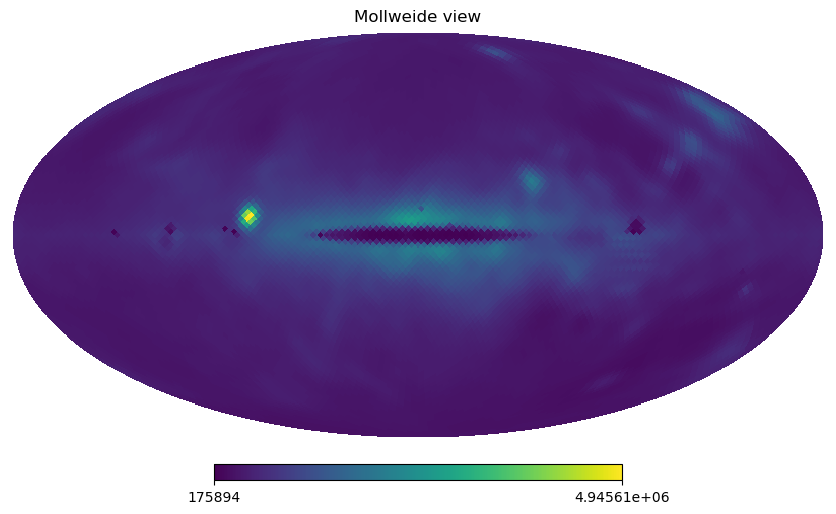

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import scipy
import py21cmsig
import lochness
import enlighten
import healpy as hp
import perses
from astropy.io import fits
import copy
import os

Prepared Haslam map in 0.11 s.
Furnsh-ing spice kernels...
Computing lunar simulation for time  [2026, 12, 22, 1, 0, 0]


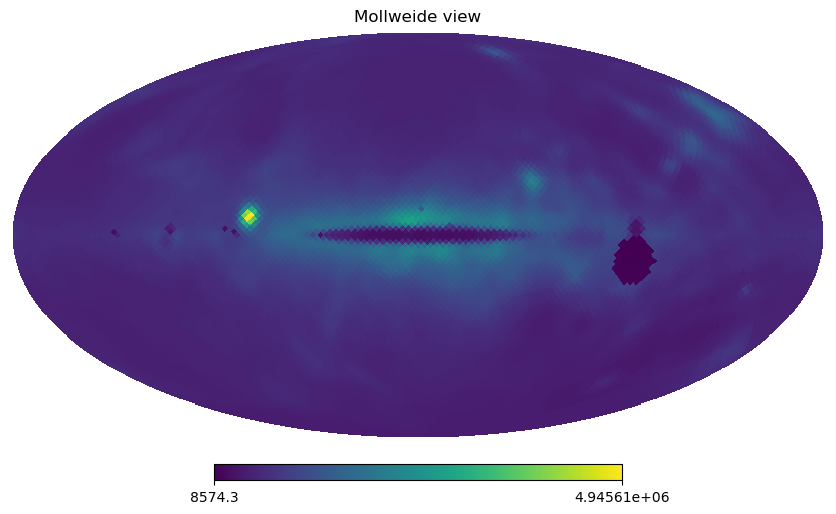

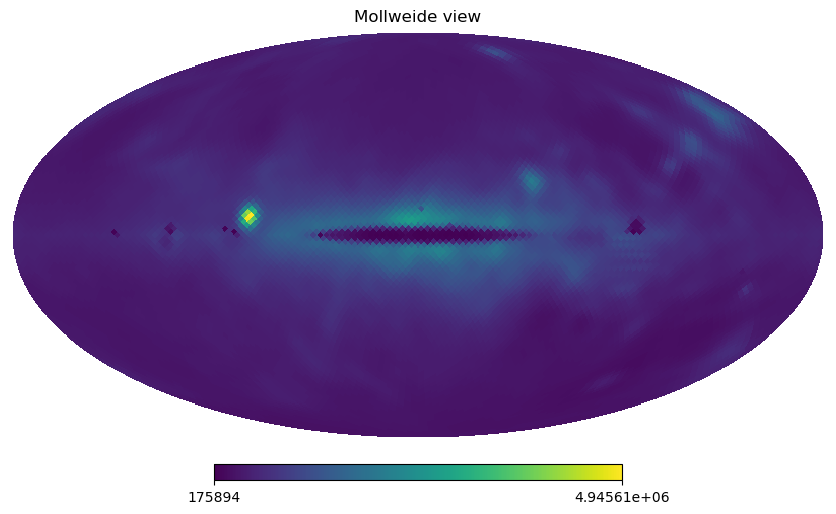

In [4]:
# Imporant constants
NSIDE = 32 # resolution of the map
NPIX = hp.nside2npix(NSIDE)
NPIX   # total number of pixels (size of the array being used)
location = (-23.815,182.25)  # The lat lon location of the moon landing site
spice_kernels = "/home/dbarker7752/lochness/input/spice_kernels/" #location of the spice kernels
frequencies = np.arange(6,50,0.1)

# Cosmological Parameters
H0 = 67.36     # Hubble constant 
h = H0/100     # H0
omM0 = 0.3152   # Omega matter today
omB0 = 0.0493   # Omega baryons today 
omK0 = 0        # Omega curvature today
omC0 = 0.2645   # Omega cold dark matter today 
#omR0 = 8.98e-5  # Omega radiation today
omR0=8.600000001024455e-05  # Omega radiation from 21cm FAST
omL0 = 0.6847   # Omega Dark Energy today

### Boilerplate arrays for healpy (changes with a change in resolution)
thetas = hp.pix2ang(NSIDE,np.arange(NPIX))[0]*(180/np.pi)
phis = hp.pix2ang(NSIDE,np.arange(NPIX))[1]*(180/np.pi)
coordinate_array = np.ones((NPIX,2))
for i in np.arange(NPIX):
    coordinate_array[i] = np.array([phis[i],thetas[i]])

# HASLAM map
gal = perses.foregrounds.HaslamGalaxy()
haslam_data=gal.get_map(39.93) # gets the actual array of the data for that haslam map

# ULSA map
ULSA_direction_raw = fits.open("/home/dbarker7752/21_cm_group/ULSA Maps/000.fits")
ULSA_frequency = fits.open("/home/dbarker7752/21_cm_group/ULSA Maps/210.fits")
ULSA_constant = fits.open("/home/dbarker7752/21_cm_group/ULSA Maps/220.fits")

# This cell fixes the hole in the ULSA data via an interpolation

# This identifies the pixels of the dead zone
vec = hp.ang2vec(np.pi/2*1.1, -np.pi/2*1.05)
indices=hp.query_disc(nside=NSIDE,vec=vec,radius=0.19)
hole_map = copy.deepcopy(ULSA_direction_raw[0].data[7])
hole_map[indices] = 10000000
hp.mollview(ULSA_direction_raw[0].data[7])
# These indices will be our region 10 which is the region we ignore
indices_deadzone = indices


x = np.arange(NPIX)
x = np.delete(x,indices_deadzone) # Gets rid of the dead zone
ULSA_min_deadzone = copy.deepcopy(ULSA_direction_raw[0].data)
for i,data in enumerate(ULSA_direction_raw[0].data):
    y = data
    y = np.delete(y,indices_deadzone)
    interpolator = scipy.interpolate.CubicSpline(x,y)
    for j in indices_deadzone:
        ULSA_min_deadzone[i][j] = interpolator(j)
hp.mollview(ULSA_min_deadzone[7])

ULSA_direction = ULSA_min_deadzone

# creates a list of all the beam file names.
path = "/home/dbarker7752/21_cm_group/Varied_Regolith/Beams"
files = []
for file in os.listdir(path):
    files.append(path+"/"+file)

# some other useful global variables
galaxy_map = ULSA_direction    # default galaxy map
test_times1 = [[2026,12,22,1,0,0]]   # list of times LOCHNESS will rotate the sky for 
frequency_array = np.array(range(1,51))   # list of frequencies we're evaluating at   

# modifies the galaxy map to not have the CMB (to make it consistent with the delta CMB convention of the signal)
galaxy_map_minCMB = copy.deepcopy(galaxy_map)
redshift_array = 1420.4/frequency_array-1
# This loop creates a CMB subtracted galaxy map to input into LOCHNESS
for i,j in enumerate(redshift_array):
    galaxy_map_minCMB[i] = galaxy_map[i] - py21cmsig.T_gamma(j)
galaxy_map_minCMB[np.where(galaxy_map_minCMB<0.0)] = 0   # Gets rid of the negatives that plague this ULSA map (not sure why they are they)
foreground_array_minCMB = lochness.LOCHNESS(spice_kernels,test_times1,location,galaxy_map=galaxy_map_minCMB).lunar_frame_galaxy_maps
foreground_array_minCMB[np.where(foreground_array_minCMB<0.0)] = 0

# radiometer noise
sigT = lambda T_b, dnu, dt: T_b/(np.sqrt(dnu*dt))
# Noise parameters
dnu = 1e6
dt = 10000*3600 # first number is the number of hours of integration time

# Synchrotron Equation
synch = lambda f,A,B,c : A*(f/408)**(B+c*np.log(f/408))  # taken from page 6 of Hibbard et al. 2023 Apj. Arbitrarily chose 25 as my v0

# This identifies the pixels of the absorption region
vec = hp.ang2vec(np.pi/2, 0)
indices=hp.query_disc(nside=NSIDE,vec=vec,radius=0.85)
absorp_map = copy.deepcopy(ULSA_direction[7])
# absorp_map[indices] = 10000000
absorp_indices = indices[np.where(absorp_map[indices] < 1450000)][750:906]
absorp_map[absorp_indices] = 10000000

manager = enlighten.get_manager()
pbar = manager.counter(total=100, desc='Progress')

n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB[0]

In [2]:
# Create the foregrounds for each LST:
# foreground_array_minCMB_2 = lochness.LOCHNESS(spice_kernels,[[2026,12,1,1,0,0]],location,galaxy_map=galaxy_map_minCMB).lunar_frame_galaxy_maps
# foreground_array_minCMB_2[np.where(foreground_array_minCMB_2<0.0)] = 0
# foreground_array_minCMB_3 = lochness.LOCHNESS(spice_kernels,[[2026,12,5,1,0,0]],location,galaxy_map=galaxy_map_minCMB).lunar_frame_galaxy_maps
# foreground_array_minCMB_3[np.where(foreground_array_minCMB_3<0.0)] = 0
# foreground_array_minCMB_4 = lochness.LOCHNESS(spice_kernels,[[2026,12,8,1,0,0]],location,galaxy_map=galaxy_map_minCMB).lunar_frame_galaxy_maps
# foreground_array_minCMB_4[np.where(foreground_array_minCMB_4<0.0)] = 0
# foreground_array_minCMB_5 = lochness.LOCHNESS(spice_kernels,[[2026,12,11,1,0,0]],location,galaxy_map=galaxy_map_minCMB).lunar_frame_galaxy_maps
# foreground_array_minCMB_5[np.where(foreground_array_minCMB_5<0.0)] = 0
# foreground_array_minCMB_6 = lochness.LOCHNESS(spice_kernels,[[2026,12,14,1,0,0]],location,galaxy_map=galaxy_map_minCMB).lunar_frame_galaxy_maps
# foreground_array_minCMB_6[np.where(foreground_array_minCMB_6<0.0)] = 0
# foreground_array_minCMB_7 = lochness.LOCHNESS(spice_kernels,[[2026,12,17,1,0,0]],location,galaxy_map=galaxy_map_minCMB).lunar_frame_galaxy_maps
# foreground_array_minCMB_7[np.where(foreground_array_minCMB_7<0.0)] = 0
# foreground_array_minCMB_8 = lochness.LOCHNESS(spice_kernels,[[2026,12,20,1,0,0]],location,galaxy_map=galaxy_map_minCMB).lunar_frame_galaxy_maps
# foreground_array_minCMB_8[np.where(foreground_array_minCMB_8<0.0)] = 0
# foreground_array_minCMB_9 = lochness.LOCHNESS(spice_kernels,[[2026,12,23,1,0,0]],location,galaxy_map=galaxy_map_minCMB).lunar_frame_galaxy_maps
# foreground_array_minCMB_9[np.where(foreground_array_minCMB_9<0.0)] = 0
# foreground_array_minCMB_10 = lochness.LOCHNESS(spice_kernels,[[2026,12,26,1,0,0]],location,galaxy_map=galaxy_map_minCMB).lunar_frame_galaxy_maps
# foreground_array_minCMB_10[np.where(foreground_array_minCMB_10<0.0)] = 0

# Save these to an hdf5 file (take a long time to make those guys)
# f = h5py.File("/home/dbarker7752/21_cm_group/Varied_Regolith/LST_10_Base_Foregrounds","w")
# dset02 = f.create_dataset("LST_2",data=foreground_array_minCMB_2)
# dset03 = f.create_dataset("LST_3",data=foreground_array_minCMB_3)
# dset04 = f.create_dataset("LST_4",data=foreground_array_minCMB_4)
# dset05 = f.create_dataset("LST_5",data=foreground_array_minCMB_5)
# dset06 = f.create_dataset("LST_6",data=foreground_array_minCMB_6)
# dset07 = f.create_dataset("LST_7",data=foreground_array_minCMB_7)
# dset08 = f.create_dataset("LST_8",data=foreground_array_minCMB_8)
# dset09 = f.create_dataset("LST_9",data=foreground_array_minCMB_9)
# dset10 = f.create_dataset("LST_10",data=foreground_array_minCMB_10)

LST = h5py.File("/home/dbarker7752/21_cm_group/Varied_Regolith/LST_10_Base_Foregrounds","r")
foreground_array_minCMB_2 = LST["LST_2"]
foreground_array_minCMB_3 = LST["LST_3"]
foreground_array_minCMB_4 = LST["LST_4"]
foreground_array_minCMB_5 = LST["LST_5"]
foreground_array_minCMB_6 = LST["LST_6"]
foreground_array_minCMB_7 = LST["LST_7"]
foreground_array_minCMB_8 = LST["LST_8"]
foreground_array_minCMB_9 = LST["LST_9"]
foreground_array_minCMB_10 = LST["LST_10"]

f = h5py.File("/home/dbarker7752/21_cm_group/Varied_Regolith/Training_Set_2","r")
varied_regolith_training_set_2 = f["Foreground_Training_Set"]
f = h5py.File("/home/dbarker7752/21_cm_group/Varied_Regolith/Training_Set_3","r")
varied_regolith_training_set_3 = f["Foreground_Training_Set"]
f = h5py.File("/home/dbarker7752/21_cm_group/Varied_Regolith/Training_Set_4","r")
varied_regolith_training_set_4 = f["Foreground_Training_Set"]
f = h5py.File("/home/dbarker7752/21_cm_group/Varied_Regolith/Training_Set_5","r")
varied_regolith_training_set_5 = f["Foreground_Training_Set"]
f = h5py.File("/home/dbarker7752/21_cm_group/Varied_Regolith/Training_Set_6","r")
varied_regolith_training_set_6 = f["Foreground_Training_Set"]
f = h5py.File("/home/dbarker7752/21_cm_group/Varied_Regolith/Training_Set_7","r")
varied_regolith_training_set_7 = f["Foreground_Training_Set"]
f = h5py.File("/home/dbarker7752/21_cm_group/Varied_Regolith/Training_Set_8","r")
varied_regolith_training_set_8 = f["Foreground_Training_Set"]
f = h5py.File("/home/dbarker7752/21_cm_group/Varied_Regolith/Training_Set_9","r")
varied_regolith_training_set_9 = f["Foreground_Training_Set"]
f = h5py.File("/home/dbarker7752/21_cm_group/Varied_Regolith/Training_Set_10","r")
varied_regolith_training_set_10 = f["Foreground_Training_Set"]

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/home/dbarker7752/21_cm_group/Varied_Regolith/Training_Set_10', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [11]:
del f

In [3]:
### Creates the HDF5 file that contains the training sets for varied regolith beams from Fatima for multiple LSTs
path = "/home/dbarker7752/21_cm_group/Varied_Regolith/Beams"
# foreground_2=py21cmsig.signal_training_set(path,foreground_array_minCMB_2,test_times1,50,3)  # creates the foreground training set
# f = h5py.File("/home/dbarker7752/21_cm_group/Varied_Regolith/Training_Set_2","w")
# dset01 = f.create_dataset("Foreground_Training_Set",data=foreground_2[0])
# dset01param = f.create_dataset("Parameters_of_Beams", data=foreground_2[1])

# foreground_3=py21cmsig.signal_training_set(path,foreground_array_minCMB_3,test_times1,50,3)  # creates the foreground training set
# f = h5py.File("/home/dbarker7752/21_cm_group/Varied_Regolith/Training_Set_3","w")
# dset01 = f.create_dataset("Foreground_Training_Set",data=foreground_3[0])
# dset01param = f.create_dataset("Parameters_of_Beams", data=foreground_3[1])

# foreground_4=py21cmsig.signal_training_set(path,foreground_array_minCMB_4,test_times1,50,3)  # creates the foreground training set
# f = h5py.File("/home/dbarker7752/21_cm_group/Varied_Regolith/Training_Set_4","w")
# dset01 = f.create_dataset("Foreground_Training_Set",data=foreground_4[0])
# dset01param = f.create_dataset("Parameters_of_Beams", data=foreground_4[1])

# foreground_5=py21cmsig.signal_training_set(path,foreground_array_minCMB_5,test_times1,50,3)  # creates the foreground training set
# f = h5py.File("/home/dbarker7752/21_cm_group/Varied_Regolith/Training_Set_5","w")
# dset01 = f.create_dataset("Foreground_Training_Set",data=foreground_5[0])
# dset01param = f.create_dataset("Parameters_of_Beams", data=foreground_5[1])

# foreground_6=py21cmsig.signal_training_set(path,foreground_array_minCMB_6,test_times1,50,3)  # creates the foreground training set
# f = h5py.File("/home/dbarker7752/21_cm_group/Varied_Regolith/Training_Set_6","w")
# dset01 = f.create_dataset("Foreground_Training_Set",data=foreground_6[0])
# dset01param = f.create_dataset("Parameters_of_Beams", data=foreground_6[1])

# foreground_7=py21cmsig.signal_training_set(path,foreground_array_minCMB_7,test_times1,50,3)  # creates the foreground training set
# f = h5py.File("/home/dbarker7752/21_cm_group/Varied_Regolith/Training_Set_7","w")
# dset01 = f.create_dataset("Foreground_Training_Set",data=foreground_7[0])
# dset01param = f.create_dataset("Parameters_of_Beams", data=foreground_7[1])

# foreground_8=py21cmsig.signal_training_set(path,foreground_array_minCMB_8,test_times1,50,3)  # creates the foreground training set
# f = h5py.File("/home/dbarker7752/21_cm_group/Varied_Regolith/Training_Set_8","w")
# dset01 = f.create_dataset("Foreground_Training_Set",data=foreground_8[0])
# dset01param = f.create_dataset("Parameters_of_Beams", data=foreground_8[1])

# foreground_9=py21cmsig.signal_training_set(path,foreground_array_minCMB_9,test_times1,50,3)  # creates the foreground training set
# f = h5py.File("/home/dbarker7752/21_cm_group/Varied_Regolith/Training_Set_9","w")
# dset01 = f.create_dataset("Foreground_Training_Set",data=foreground_9[0])
# dset01param = f.create_dataset("Parameters_of_Beams", data=foreground_9[1])

foreground_10=py21cmsig.signal_training_set(path,foreground_array_minCMB_10,test_times1,50,3)  # creates the foreground training set
f = h5py.File("/home/dbarker7752/21_cm_group/Varied_Regolith/Training_Set_10","w")
dset01 = f.create_dataset("Foreground_Training_Set",data=foreground_10[0])
dset01param = f.create_dataset("Parameters_of_Beams", data=foreground_10[1])

NameError: name 'test_times1' is not defined

array([[1.00890327e+08, 2.12857930e+07, 8.03236541e+06, 3.95503076e+06,
        2.26714414e+06, 1.43373157e+06, 9.70972841e+05, 6.93314459e+05,
        5.16094680e+05, 3.96565031e+05, 3.12145970e+05, 2.50592458e+05,
        2.04466380e+05, 1.69338626e+05, 1.42119225e+05, 1.20739422e+05,
        1.03614458e+05, 8.96697771e+04, 7.81672130e+04, 6.86179037e+04,
        6.06276809e+04, 5.38382012e+04, 4.79886322e+04, 4.29559139e+04,
        3.87416341e+04, 3.52847855e+04, 3.23283766e+04, 2.96704644e+04,
        2.72550997e+04, 2.50631993e+04, 2.30838303e+04, 2.13024697e+04,
        1.96982647e+04, 1.82530691e+04, 1.69492499e+04, 1.57675302e+04,
        1.46937912e+04, 1.37159775e+04, 1.28247378e+04, 1.20157578e+04,
        1.12822777e+04, 1.06087520e+04, 9.98748653e+03, 9.42293400e+03,
        8.91071644e+03, 8.44064953e+03, 8.01126810e+03, 7.62129688e+03,
        7.26249203e+03, 6.92434275e+03]])